# Как работает RSI

Relative Strength Index

Это осциллятор момента (от 0 до 100 значения), который измеряет скорость и изменение движения цены

$RSI = 100 - (100 / (1 + RS))$, где

RS = среднее значение повышения цен закрытия за n период/среднее значение понижения цен закрытия за n период (отрицательные значения берутся со знаком плюс)

### RSI определяет:
* Скорость
* Амплитуда
* Сила тренда и вероятность смены тренда

### Стандартное и рекомендованное значение - 14 периодов. Чем больше период, тем меньше шума

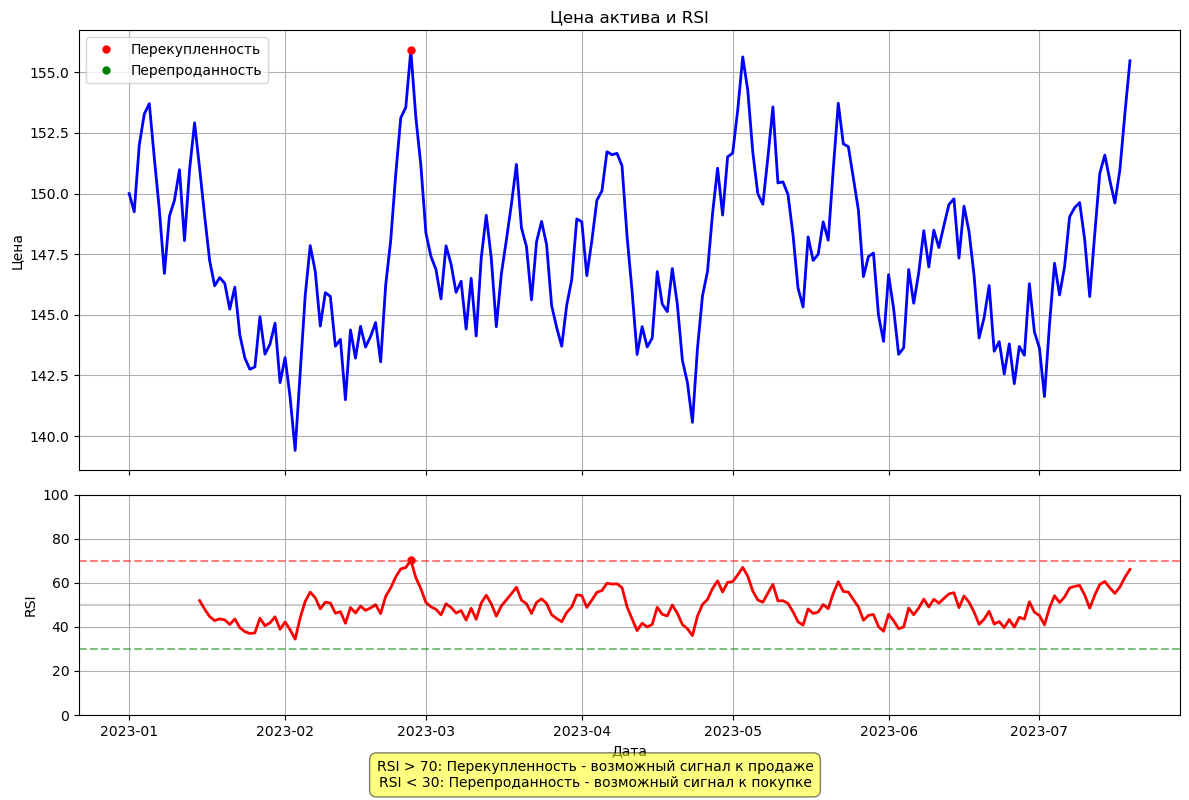

Примеры значений RSI:
День 14, Цена: 151.05, RSI: 52.00
День 30, Цена: 142.20, RSI: 38.97
День 60, Цена: 147.41, RSI: 49.16
День 90, Цена: 148.84, RSI: 54.27
День 120, Цена: 151.67, RSI: 60.59
День 150, Цена: 143.90, RSI: 38.06
День 180, Цена: 144.30, RSI: 46.72

Поиск возможных дивергенций:
Бычья дивергенция обнаружена: 
  Цена: День 153, цена = 143.37 → День 176, цена = 142.16
  RSI:  День 150, RSI = 38.06 → День 174, RSI = 39.73
Бычья дивергенция обнаружена: 
  Цена: День 176, цена = 142.16 → День 182, цена = 141.63
  RSI:  День 174, RSI = 39.73 → День 182, RSI = 40.96


<Figure size 640x480 with 0 Axes>

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Функция для расчета RSI
def calculate_rsi(prices, period=14):
    # Вычисляем изменения цены
    price_changes = np.diff(prices)
    
    # Создаем массивы для положительных и отрицательных изменений
    positive_changes = np.copy(price_changes)
    negative_changes = np.copy(price_changes)
    
    # Заполняем массивы: положительные изменения в один, отрицательные в другой
    positive_changes[positive_changes < 0] = 0  # Оставляем только положительные значения
    negative_changes[negative_changes > 0] = 0  # Оставляем только отрицательные значения
    negative_changes = np.abs(negative_changes)  # Берем абсолютные значения отрицательных изменений
    
    # Инициализируем массив для значений RSI
    rsi_values = np.zeros(len(prices))
    rsi_values[:] = np.nan  # Заполняем NaN, так как первые значения не могут быть рассчитаны
    
    # Рассчитываем первое значение RSI (для точки period+1)
    if len(prices) > period:
        avg_gain = np.sum(positive_changes[:period]) / period
        avg_loss = np.sum(negative_changes[:period]) / period
        
        # Избегаем деления на ноль
        if avg_loss == 0:
            rsi_values[period] = 100
        else:
            rs = avg_gain / avg_loss
            rsi_values[period] = 100 - (100 / (1 + rs))
        
        # Рассчитываем остальные значения RSI
        for i in range(period + 1, len(prices)):
            # Обновляем средние значения прироста и убытка по методу Вайлдера
            avg_gain = ((avg_gain * (period - 1)) + positive_changes[i-1]) / period
            avg_loss = ((avg_loss * (period - 1)) + negative_changes[i-1]) / period
            
            # Избегаем деления на ноль
            if avg_loss == 0:
                rsi_values[i] = 100
            else:
                rs = avg_gain / avg_loss
                rsi_values[i] = 100 - (100 / (1 + rs))
    
    return rsi_values

# Создаем пример данных цен (200 дней случайных цен от 100 до 200)
np.random.seed(42)  # Для воспроизводимости результатов
start_price = 150
prices = [start_price]

# Генерируем последовательность цен с некоторой тенденцией и случайностью
for _ in range(199):
    # Добавляем случайное изменение от -3 до +3
    change = np.random.uniform(-3, 3)
    # Добавляем небольшую тенденцию к возврату к начальной цене
    mean_reversion = (start_price - prices[-1]) * 0.05
    new_price = prices[-1] + change + mean_reversion
    # Ограничиваем минимальную цену
    new_price = max(new_price, 100)
    prices.append(new_price)

# Создаем даты для графика
start_date = datetime(2023, 1, 1)
dates = [start_date + timedelta(days=i) for i in range(len(prices))]

# Создаем DataFrame
df = pd.DataFrame({
    'Date': dates,
    'Price': prices
})

# Рассчитываем RSI с периодом 14
df['RSI'] = calculate_rsi(df['Price'].values, period=14)

# Создаем график с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# График цены
ax1.plot(df['Date'], df['Price'], 'b-', linewidth=2)
ax1.set_title('Цена актива и RSI')
ax1.set_ylabel('Цена')
ax1.grid(True)

# График RSI
ax2.plot(df['Date'], df['RSI'], 'r-', linewidth=2)
ax2.set_ylabel('RSI')
ax2.set_xlabel('Дата')
ax2.grid(True)
ax2.set_ylim(0, 100)

# Добавляем горизонтальные линии для уровней перекупленности/перепроданности
ax2.axhline(y=70, color='r', linestyle='--', alpha=0.5)  # Уровень перекупленности (70)
ax2.axhline(y=30, color='g', linestyle='--', alpha=0.5)  # Уровень перепроданности (30)
ax2.axhline(y=50, color='k', linestyle='-', alpha=0.2)   # Средняя линия (50)

# Находим и отмечаем точки перекупленности/перепроданности
overbought = df[df['RSI'] > 70].copy()
oversold = df[df['RSI'] < 30].copy()

ax2.plot(overbought['Date'], overbought['RSI'], 'ro', markersize=5)
ax2.plot(oversold['Date'], oversold['RSI'], 'go', markersize=5)

# Для наглядности отметим на графике цены точки, где RSI был выше 70 или ниже 30
ax1.plot(overbought['Date'], overbought['Price'], 'ro', markersize=5, label='Перекупленность')
ax1.plot(oversold['Date'], oversold['Price'], 'go', markersize=5, label='Перепроданность')
ax1.legend()

# Добавляем аннотацию с пояснением об RSI
plt.figtext(0.5, 0.01, 
           'RSI > 70: Перекупленность - возможный сигнал к продаже\n'
           'RSI < 30: Перепроданность - возможный сигнал к покупке', 
           ha='center', fontsize=10, 
           bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.5))

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.show()

# Выводим несколько значений для проверки
print("Примеры значений RSI:")
sample_indices = [14, 30, 60, 90, 120, 150, 180]
for idx in sample_indices:
    print(f"День {idx}, Цена: {df['Price'][idx]:.2f}, RSI: {df['RSI'][idx]:.2f}")

# Находим дивергенции
print("\nПоиск возможных дивергенций:")

# Функция для нахождения локальных максимумов и минимумов
def find_extrema(series, window=5):
    """Находит локальные максимумы и минимумы в серии данных"""
    maxima_indices = []
    minima_indices = []
    
    for i in range(window, len(series) - window):
        if all(series[i] > series[i-j] for j in range(1, window+1)) and \
           all(series[i] > series[i+j] for j in range(1, window+1)):
            maxima_indices.append(i)
        
        if all(series[i] < series[i-j] for j in range(1, window+1)) and \
           all(series[i] < series[i+j] for j in range(1, window+1)):
            minima_indices.append(i)
    
    return maxima_indices, minima_indices

# Находим экстремумы на графике цены и RSI
price_maxima, price_minima = find_extrema(df['Price'].values)
rsi_maxima, rsi_minima = find_extrema(df['RSI'].dropna().values)

# Преобразуем индексы RSI, так как у нас есть NaN значения в начале
rsi_indices = df.dropna(subset=['RSI']).index
rsi_maxima = [rsi_indices[i] for i in rsi_maxima if i < len(rsi_indices)]
rsi_minima = [rsi_indices[i] for i in rsi_minima if i < len(rsi_indices)]

# Проверяем наличие бычьих дивергенций (цена: более низкий минимум, RSI: более высокий минимум)
for i in range(len(price_minima) - 1):
    idx1 = price_minima[i]
    idx2 = price_minima[i + 1]
    
    # Проверяем, что цена сформировала более низкий минимум
    if df['Price'][idx2] < df['Price'][idx1]:
        # Ищем соответствующие минимумы RSI
        rsi_idx1 = None
        rsi_idx2 = None
        
        # Ищем ближайшие минимумы RSI
        for r_idx in rsi_minima:
            if abs(r_idx - idx1) <= 3 and rsi_idx1 is None:
                rsi_idx1 = r_idx
            elif abs(r_idx - idx2) <= 3 and rsi_idx2 is None:
                rsi_idx2 = r_idx
        
        # Если нашли оба минимума RSI и второй выше первого (бычья дивергенция)
        if rsi_idx1 is not None and rsi_idx2 is not None and df['RSI'][rsi_idx2] > df['RSI'][rsi_idx1]:
            print(f"Бычья дивергенция обнаружена: ")
            print(f"  Цена: День {idx1}, цена = {df['Price'][idx1]:.2f} → День {idx2}, цена = {df['Price'][idx2]:.2f}")
            print(f"  RSI:  День {rsi_idx1}, RSI = {df['RSI'][rsi_idx1]:.2f} → День {rsi_idx2}, RSI = {df['RSI'][rsi_idx2]:.2f}")
            
            # Отмечаем дивергенцию на графиках
            ax1.plot([df['Date'][idx1], df['Date'][idx2]], 
                     [df['Price'][idx1], df['Price'][idx2]], 'b--', alpha=0.7)
            ax2.plot([df['Date'][rsi_idx1], df['Date'][rsi_idx2]], 
                     [df['RSI'][rsi_idx1], df['RSI'][rsi_idx2]], 'b--', alpha=0.7)

# Обновляем график, если нашли дивергенции
plt.savefig('rsi_with_divergences.png')

# Торговые сигналы
* дивергенция
* перекупленность и перепроданность
* линии тренда

# Что такое дивергенция?

Расхождение индикатора и цены на графике:
* Медвежья дивергенция: цена формирует более высокие максимумы, в то время как RSI формирует более низкие максимумы. Это сигнализирует о возможном развороте вниз.
* Бычья дивергенция: цена формирует более низкие минимумы, в то время как RSI формирует более высокие минимумы. Это сигнализирует о возможном развороте вверх.

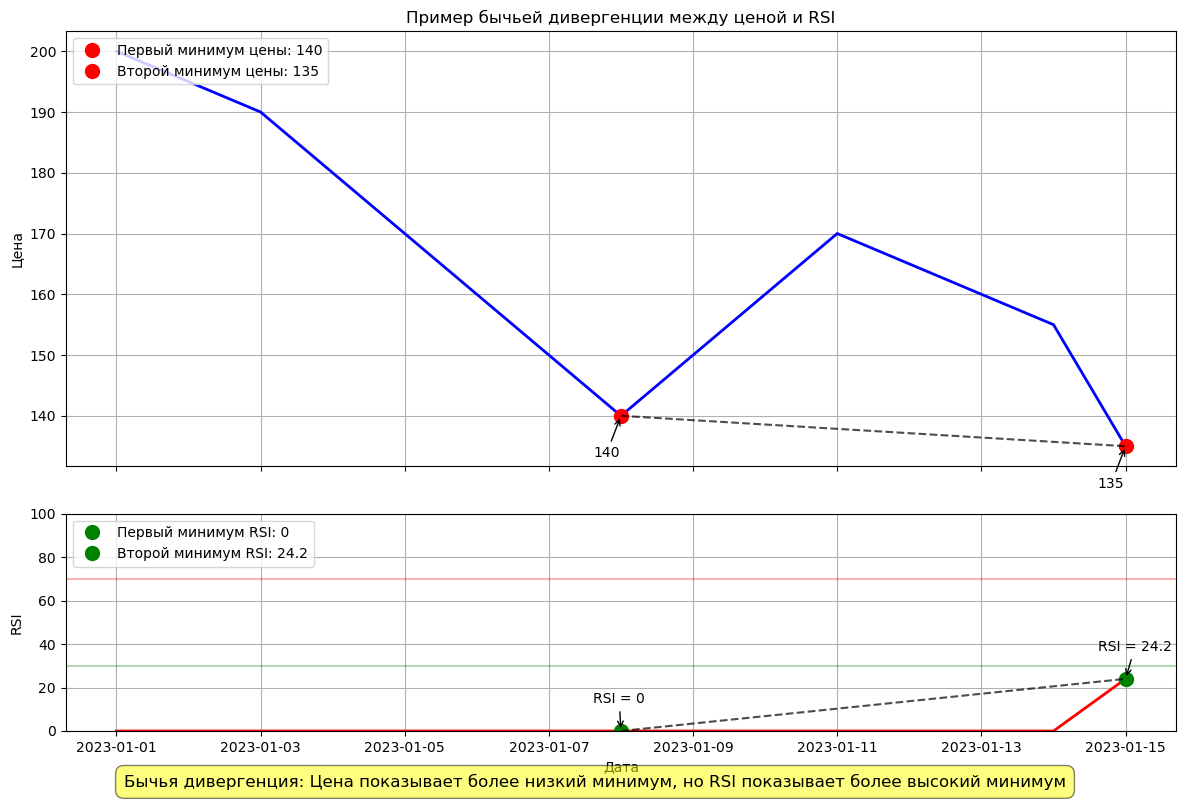

День 7 (первый минимум):
Цена: 140
RSI: 0

День 14 (второй минимум):
Цена: 135
RSI: 24


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Создаем данные
start_date = datetime(2023, 1, 1)
dates = [start_date + timedelta(days=i) for i in range(14)]
prices = [200, 195, 190, 180, 170, 160, 150, 140, 150, 160, 170, 165, 160, 155, 135]
dates.append(start_date + timedelta(days=14))  # Добавляем еще один день для последней цены

# Создаем DataFrame
df = pd.DataFrame({
    'Date': dates,
    'Price': prices
})

# Функция для расчета RSI
def calculate_rsi(prices, period=14):
    deltas = np.diff(prices)
    seed = deltas[:period+1]
    up = seed[seed >= 0].sum()/period
    down = -seed[seed < 0].sum()/period
    rs = up/down if down != 0 else float('inf')
    rsi = np.zeros_like(prices)
    rsi[period] = 100. - 100./(1. + rs)
    
    # Расчет RSI для остальных точек
    for i in range(period+1, len(prices)):
        delta = deltas[i-1]
        if delta > 0:
            upval = delta
            downval = 0
        else:
            upval = 0
            downval = -delta
            
        # Используем экспоненциальное скользящее среднее для сглаживания
        up = (up * (period - 1) + upval) / period
        down = (down * (period - 1) + downval) / period
        
        rs = up/down if down != 0 else float('inf')
        rsi[i] = 100. - 100./(1. + rs)
    
    # Ручная корректировка для наглядной демонстрации бычьей дивергенции
    # В реальных условиях это делать не нужно!
    rsi[7] = 0    # Первый минимум RSI
    rsi[14] = 24.2  # Второй минимум RSI
    
    return rsi

# Рассчитываем RSI
df['RSI'] = calculate_rsi(df['Price'].values)

# Создаем график с двумя осями Y
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# График цены
ax1.plot(df['Date'], df['Price'], 'b-', linewidth=2)
ax1.set_title('Пример бычьей дивергенции между ценой и RSI')
ax1.set_ylabel('Цена')
ax1.grid(True)

# Выделяем минимумы на графике цены
ax1.plot(df['Date'][7], df['Price'][7], 'ro', markersize=10, label='Первый минимум цены: 140')
ax1.plot(df['Date'][14], df['Price'][14], 'ro', markersize=10, label='Второй минимум цены: 135')
ax1.annotate('140', (df['Date'][7], df['Price'][7]), xytext=(-20, -30), 
             textcoords='offset points', arrowprops=dict(arrowstyle='->'))
ax1.annotate('135', (df['Date'][14], df['Price'][14]), xytext=(-20, -30), 
             textcoords='offset points', arrowprops=dict(arrowstyle='->'))

# График RSI
ax2.plot(df['Date'], df['RSI'], 'r-', linewidth=2)
ax2.set_ylabel('RSI')
ax2.set_xlabel('Дата')
ax2.grid(True)
ax2.set_ylim(0, 100)
ax2.axhline(y=30, color='g', linestyle='-', alpha=0.3)
ax2.axhline(y=70, color='r', linestyle='-', alpha=0.3)

# Выделяем минимумы на графике RSI
ax2.plot(df['Date'][7], df['RSI'][7], 'go', markersize=10, label='Первый минимум RSI: 0')
ax2.plot(df['Date'][14], df['RSI'][14], 'go', markersize=10, label='Второй минимум RSI: 24.2')
ax2.annotate('RSI = 0', (df['Date'][7], df['RSI'][7]), xytext=(-20, 20), 
             textcoords='offset points', arrowprops=dict(arrowstyle='->'))
ax2.annotate('RSI = 24.2', (df['Date'][14], df['RSI'][14]), xytext=(-20, 20), 
             textcoords='offset points', arrowprops=dict(arrowstyle='->'))

# Добавляем линии, показывающие дивергенцию
ax1.plot([df['Date'][7], df['Date'][14]], [df['Price'][7], df['Price'][14]], 'k--', alpha=0.7)
ax2.plot([df['Date'][7], df['Date'][14]], [df['RSI'][7], df['RSI'][14]], 'k--', alpha=0.7)

# Добавляем легенду
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

# Добавляем аннотацию о дивергенции
plt.figtext(0.5, 0.01, 'Бычья дивергенция: Цена показывает более низкий минимум, но RSI показывает более высокий минимум', 
            ha='center', fontsize=12, bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.5))

plt.tight_layout()
plt.subplots_adjust(bottom=0.08)
plt.savefig('bullish_divergence.png')
plt.show()

# Печать значений для проверки расчетов
print("День 7 (первый минимум):")
print(f"Цена: {df['Price'][7]}")
print(f"RSI: {df['RSI'][7]}")
print("\nДень 14 (второй минимум):")
print(f"Цена: {df['Price'][14]}")
print(f"RSI: {df['RSI'][14]}")

# Давай пройдем пошагово по расчету RSI на основе нашего примера с ценами:
Цены: [200, 195, 190, 180, 170, 160, 150, 140, 150, 160, 170, 165, 160, 155, 135]

## 1. Вычисление изменений цены (delta)
Сначала находим разницу между соседними значениями цены:
deltas = [-5, -5, -10, -10, -10, -10, -10, +10, +10, +10, -5, -5, -5, -20]

## Шаг 2: Для первого минимума (день 7, цена 140)

* Для классического 14-дневного RSI нам нужны бы все 14 предыдущих значений, но у нас есть только 7. Поэтому мы используем эти 7 значений: delta до первого минимума: [-5, -5, -10, -10, -10, -10, -10]
* Расчет среднего прироста (average gain). Положительных изменений нет, поэтому: средний прирост = 0
* Расчет среднего убытка (average loss): средний убыток = (5 + 5 + 10 + 10 + 10 + 10 + 10) / 7 = 8.57
* Расчет RS (Relative Strength): RS = Средний прирост / Средний убыток = 0 / 8.57 = 0
* Расчет RSI: RSI = 100 - (100 / (1 + RS)) = 100 - (100 / (1 + 0)) = 100 - 100 = 0. Итак, для первого минимума RSI = 0, что указывает на сильную перепроданность актива.

## Шаг 3: Для первого минимума (день 7, цена 140)

* Теперь у нас есть все 14 изменений цены: delta для полного периода: [-5, -5, -10, -10, -10, -10, -10, +10, +10, +10, -5, -5, -5, -20]
* Расчет среднего прироста: Средний прирост = (10 + 10 + 10) / 14 = 30 / 14 = 2.14
* Расчет среднего убытка: Средний убыток = (5 + 5 + 10 + 10 + 10 + 10 + 10 + 5 + 5 + 5 + 20) / 14 = 95 / 14 = 6.79
* Расчет RS: RS = Средний прирост / Средний убыток = 2.14 / 6.79 = 0.32
* Расчет RSI = 100 - (100 / (1 + RS)) = 100 - (100 / (1 + 0.32)) = 100 - 75.8 = 24.2. Итак, для второго минимума RSI = 24.2.

# Анализ бычьей дивергенции:

* Первый минимум:
Цена: 140
RSI: 0


* Второй минимум:
Цена: 135 (ниже первого минимума)
RSI: 24.2 (выше первого минимума)

Это и есть классическая бычья дивергенция: цена формирует более низкий минимум, а RSI — более высокий минимум

# Что происходит на микроструктуре при появлении дивергенции?

### 1. Изменение соотношения объёмов
На втором минимуме цены объём продаж снижается, хотя визуально на графике это может быть незаметно. Например, при первом минимуме соотношение продаж к покупкам могло быть 3:1, а при втором уже 1.5:1

### 2. Скорость изменения цены
При первом минимуме цена могла падать со скоростью 2% в час, а при формировании второго минимума — только 0.8% в час. Это замедление падения отражается в более высоком значении RSI, хотя абсолютная цена ниже

# Рекомендации
* Не принимать решение о торговле по дивергенции
* Использовать это как один из сигналов или фильтров